In [33]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

In [34]:
d_model = 512
droput = 0.1
max_len = 60

In [35]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


input = torch.tensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedding = Embeddings(d_model, 1000)
output = embedding(input)
print(output.size())

pe = PositionalEncoding(d_model, droput, max_len)
pe_result = pe(output)
print(pe_result)
print(pe_result.size())

torch.Size([2, 4, 512])
tensor([[[-37.9372,  -8.3178, -20.8437,  ..., -21.8127,   4.1938, -23.6357],
         [ 33.3976,   1.9383, -28.5357,  ...,   0.0000,  -2.5832,  14.5427],
         [-21.7085,  -4.3570,  10.0749,  ...,  24.6697,  24.2017,  -0.0000],
         [ 35.4866, -20.3108, -17.1509,  ...,  -9.1336,   2.3938, -25.6352]],

        [[-22.7189,  -2.7836,   9.0345,  ...,  24.6697,  24.2014, -17.3210],
         [-19.8905,   0.0000, -24.8908,  ...,  -2.9568, -11.1497, -21.8079],
         [ 33.4729,   0.8756,  -0.0000,  ...,  49.9114,  -2.5831,  14.5427],
         [ -1.0743,   9.6590,   3.2216,  ...,  15.1397,  27.9076,   8.5905]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


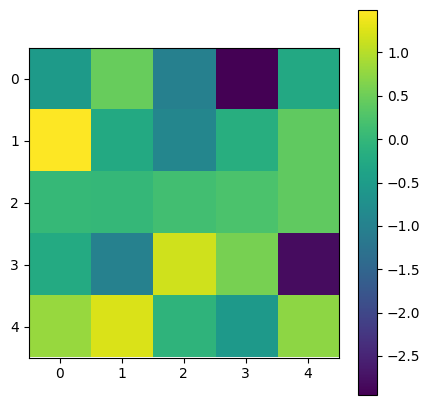

In [36]:
input = torch.randn(5, 5)
plt.figure(figsize=(5, 5))
plt.imshow(input)
plt.colorbar()
plt.show()

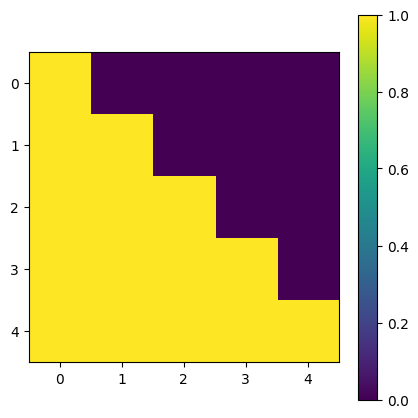

In [37]:
def subsequent_mask(sz):
    attn_shape = (1, sz, sz)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(1 - subsequent_mask)


seq_mask = subsequent_mask(5)
plt.figure(figsize=(5, 5))
plt.imshow(seq_mask[0])
plt.colorbar()
plt.show()

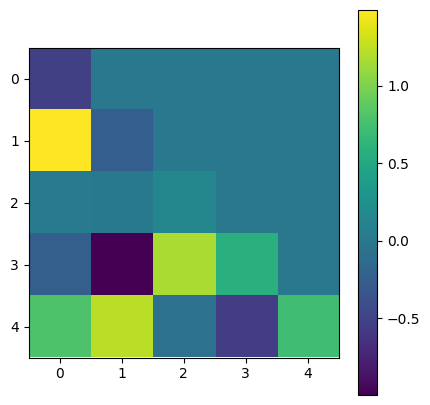

In [38]:
masked_input = input.masked_fill(seq_mask[0] == 0, 1e-9)
plt.figure(figsize=(5, 5))
plt.imshow(masked_input)
plt.colorbar()
plt.show()

In [39]:
def attention(q, k, v, mask=None, dropout=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_atten = torch.softmax(scores, dim=-1)
    if dropout is not None:
        p_atten = dropout(p_atten)
    return torch.matmul(p_atten, v), p_atten


query = key = value = pe_result
atten, p_atten = attention(query, key, value)

print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

atten: tensor([[[-37.9372,  -8.3178, -20.8437,  ..., -21.8127,   4.1938, -23.6357],
         [ 33.3976,   1.9383, -28.5357,  ...,   0.0000,  -2.5832,  14.5427],
         [-21.7085,  -4.3570,  10.0749,  ...,  24.6697,  24.2017,   0.0000],
         [ 35.4866, -20.3108, -17.1509,  ...,  -9.1336,   2.3938, -25.6352]],

        [[-22.7189,  -2.7836,   9.0345,  ...,  24.6697,  24.2014, -17.3210],
         [-19.8905,   0.0000, -24.8908,  ...,  -2.9568, -11.1497, -21.8079],
         [ 33.4729,   0.8756,   0.0000,  ...,  49.9114,  -2.5831,  14.5427],
         [ -1.0743,   9.6590,   3.2216,  ...,  15.1397,  27.9076,   8.5905]]],
       grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)


In [40]:
mask = torch.zeros(4, 4)
atten, p_atten = attention(query, key, value, mask=mask)
print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

atten: tensor([[[  2.3096,  -7.7618, -14.1138,  ...,  -1.5692,   7.0515,  -8.6821],
         [  2.3096,  -7.7618, -14.1138,  ...,  -1.5692,   7.0515,  -8.6821],
         [  2.3096,  -7.7618, -14.1138,  ...,  -1.5692,   7.0515,  -8.6821],
         [  2.3096,  -7.7618, -14.1138,  ...,  -1.5692,   7.0515,  -8.6821]],

        [[ -2.5527,   1.9378,  -3.1587,  ...,  21.6910,   9.5941,  -3.9989],
         [ -2.5527,   1.9378,  -3.1587,  ...,  21.6910,   9.5941,  -3.9989],
         [ -2.5527,   1.9378,  -3.1587,  ...,  21.6910,   9.5941,  -3.9989],
         [ -2.5527,   1.9378,  -3.1587,  ...,  21.6910,   9.5941,  -3.9989]]],
       grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.250

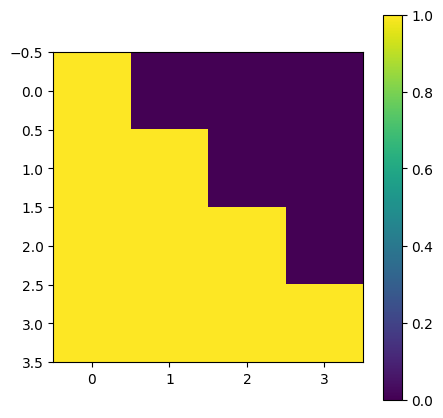

atten: tensor([[[-37.9372,  -8.3178, -20.8437,  ..., -21.8127,   4.1938, -23.6357],
         [ 33.3976,   1.9383, -28.5357,  ...,   0.0000,  -2.5832,  14.5427],
         [-21.7085,  -4.3570,  10.0749,  ...,  24.6697,  24.2017,   0.0000],
         [ 35.4866, -20.3108, -17.1509,  ...,  -9.1336,   2.3938, -25.6352]],

        [[-22.7189,  -2.7836,   9.0345,  ...,  24.6697,  24.2014, -17.3210],
         [-19.8905,   0.0000, -24.8908,  ...,  -2.9568, -11.1497, -21.8079],
         [ 33.4729,   0.8756,   0.0000,  ...,  49.9114,  -2.5831,  14.5427],
         [ -1.0743,   9.6590,   3.2216,  ...,  15.1397,  27.9076,   8.5905]]],
       grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)


In [41]:
mask = subsequent_mask(4)
plt.figure(figsize=(5, 5))
plt.imshow(mask[0])
plt.colorbar()
plt.show()

atten, p_atten = attention(query, key, value, mask=mask)
print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

In [42]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        # 需要4个线性连接层，前三个分别用于qkv，最后一个用于全连接层
        self.linears = clones(nn.Linear(d_model, d_model), 4)

        self.atten = None
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        # 如果存在掩码张量，对mask进行扩展，代表第n个头
        if mask is not None:
            mask = mask.unsqueeze(1)

        # 获取batch_size, 是query的第1个数据，代表有多少个样本
        batch_size = q.shape[0]
        query, key, value = [model(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) for model, x in
                             zip(self.linears, (q, k, v))]

        x, self.atten = attention(query, key, value, mask=self.atten, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

        return self.linears[-1](x)


multihead_attention = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
output = multihead_attention(query, key, value, mask=mask)

In [43]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        """
        d_model 是线性层输入的维度
        d_ff 是中间层的维度
        Positionwise 表示输入输出维度大小一致
        """
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(torch.relu(self.w1(x))))


d_model = 512
d_ff = 64
dropout = 0.2

ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(output)
print(ff_result)
print(ff_result.size())

tensor([[[-0.4993, -4.6847,  1.4359,  ...,  1.4464, -2.4249, -1.3964],
         [-5.6428, -5.2817,  0.7850,  ...,  1.9915, -1.4695, -0.0466],
         [-4.1452,  0.6525, -0.2792,  ...,  1.4726, -1.6080, -0.1487],
         [-1.7646, -2.0211,  2.3400,  ...,  4.2543, -1.3883,  1.3604]],

        [[-1.6055, -3.6556,  0.7485,  ...,  1.2585, -3.4478, -1.7130],
         [-1.6591,  0.9240,  0.8110,  ...,  0.8902, -2.4165, -0.3619],
         [-4.5292, -3.4336,  1.5771,  ..., -0.3287, -1.1225, -1.4454],
         [-3.5078,  0.0187,  4.0443,  ...,  1.8273,  0.1579,  2.2021]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


In [44]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        """
        d_model 表示词嵌入的维度
        eps 是一个很小的数，防止除0的问题
        """
        super(LayerNorm, self).__init__()

        # 跟据词嵌入的维度定义a2和b2，一个全是1，一个全是0，用nn.parameter封装，表示为模型参数，在训练的时候进行更新
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # * 表示同型点乘，即表示对应位置的乘法，加法表示对应位置加法
        return self.a * (x - mean) / (std + self.eps) + self.b


norm = LayerNorm(d_model)
norm_result = norm(ff_result)
print(norm_result)
print(norm_result.size())

tensor([[[-0.1895, -2.2387,  0.7580,  ...,  0.7631, -1.1323, -0.6288],
         [-2.0602, -1.9231,  0.3799,  ...,  0.8379, -0.4759,  0.0642],
         [-1.4815,  0.2559, -0.0815,  ...,  0.5529, -0.5627, -0.0343],
         [-0.5778, -0.6675,  0.8584,  ...,  1.5282, -0.4461,  0.5156]],

        [[-0.7909, -1.8897,  0.4709,  ...,  0.7443, -1.7783, -0.8485],
         [-0.6849,  0.4555,  0.4056,  ...,  0.4405, -1.0192, -0.1122],
         [-2.1581, -1.6196,  0.8433,  ..., -0.0934, -0.4836, -0.6423],
         [-1.6974,  0.0468,  2.0379,  ...,  0.9414,  0.1157,  1.1267]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [45]:
class SublayerConnection(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(SublayerConnection, self).__init__()

        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # 将输入进行规范化处理，将结果传入子层，再进行dropout
        # 最后是跳跃链接，
        return x + self.dropout(sublayer(self.norm(x)))


x = pe_result
mask = torch.zeros(4, 4)
self_att = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
sublayer = lambda x: self_att(x, x, x, mask)

sc = SublayerConnection(d_model, dropout=droput)
sc_result = sc(x, sublayer)
print(sc_result)
print(sc_result.size())


tensor([[[-37.6646,  -8.0949, -20.8894,  ..., -22.3556,   4.1723, -23.8357],
         [ 33.7517,   1.9058, -28.2860,  ...,  -0.9474,  -2.5678,  14.5575],
         [-21.4745,  -3.7824,   9.9256,  ...,  24.7152,  24.1492,   0.2274],
         [ 35.5312, -20.1835, -17.7633,  ...,  -8.8728,   2.7098, -25.4631]],

        [[-22.5260,  -2.5379,   9.3154,  ...,  24.6697,  24.3289, -17.3368],
         [-19.9940,  -0.2767, -24.5550,  ...,  -3.1472, -10.6701, -21.6779],
         [ 33.7769,   0.8801,   0.4624,  ...,  48.8072,  -2.5751,  14.8026],
         [ -1.3648,   9.3003,   3.6353,  ...,  15.1397,  27.9076,   8.7147]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [46]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, self_atten, feed_forward, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.self_atten = self_atten
        self.feed_forward = feed_forward

        self.sublayers = clones(SublayerConnection(d_model, dropout), 2)
        self.d_model = d_model

    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x: self_att(x, x, x, mask))
        return self.sublayers[1](x, self.feed_forward)


x = pe_result
mask = torch.zeros(4, 4)
self_atten = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
el = EncoderLayer(d_model, self_atten, feed_forward, dropout)
x_result = el(x, mask)
print(x_result)
print(x_result.size())

tensor([[[-3.7840e+01, -7.6047e+00, -2.0958e+01,  ..., -2.1824e+01,
           4.2286e+00, -2.3449e+01],
         [ 3.3718e+01,  2.2865e+00, -2.8158e+01,  ..., -1.2156e+00,
          -2.8231e+00,  1.5196e+01],
         [-2.1656e+01, -4.3570e+00,  9.8709e+00,  ...,  2.4966e+01,
           2.3566e+01, -1.7104e-02],
         [ 3.5602e+01, -1.9898e+01, -1.8227e+01,  ..., -9.1683e+00,
           1.9643e+00, -2.6079e+01]],

        [[-2.2857e+01, -2.9678e+00,  8.3994e+00,  ...,  2.4113e+01,
           2.3806e+01, -1.7352e+01],
         [-2.0104e+01, -5.6465e-01, -2.4515e+01,  ..., -2.9568e+00,
          -1.1290e+01, -2.1134e+01],
         [ 3.3800e+01,  7.0023e-01,  6.9399e-01,  ...,  4.9119e+01,
          -2.4233e+00,  1.5209e+01],
         [-1.1925e+00,  9.3324e+00,  3.7835e+00,  ...,  1.4786e+01,
           2.7983e+01,  8.8573e+00]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [47]:
print(self_atten)
print(el)

MultiHeadAttention(
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
EncoderLayer(
  (self_atten): MultiHeadAttention(
    (linears): ModuleList(
      (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
    (w1): Linear(in_features=512, out_features=64, bias=True)
    (w2): Linear(in_features=64, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (sublayers): ModuleList(
    (0-1): 2 x SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
)


In [57]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()

        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.d_model)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)


encoder = Encoder(EncoderLayer(d_model, copy.deepcopy(self_atten), copy.deepcopy(feed_forward), dropout), 5)
encoder_result = encoder(x, mask)
print(encoder)


Encoder(
  (layers): ModuleList(
    (0-4): 5 x EncoderLayer(
      (self_atten): MultiHeadAttention(
        (linears): ModuleList(
          (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (w1): Linear(in_features=512, out_features=64, bias=True)
        (w2): Linear(in_features=64, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (sublayers): ModuleList(
        (0-1): 2 x SublayerConnection(
          (norm): LayerNorm()
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (norm): LayerNorm()
)
